In [43]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import resize, rgb_to_grayscale
from tensorflow import expand_dims
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [9]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

In [11]:
data=pd.read_csv('./fer2013.csv')

In [12]:
data['pixels']=data['pixels'].astype("string")
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(data['emotion']).to_numpy()

In [13]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [15]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

In [16]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [17]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [18]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [19]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [20]:
xception = Model(inputs, outputs,name="Xception")

In [21]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 24, 32)   0           ['batch_normalization[0][0

In [22]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=50, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_Xception'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [23]:
xception_history =xception.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
785/785 [==============================] - ETA: 0s - loss: 1.6691 - accuracy: 0.3364
Epoch 1: val_loss improved from inf to 2.35763, saving model to models\_Xception.01-0.31.hdf5
785/785 [==============================] - 166s 204ms/step - loss: 1.6691 - accuracy: 0.3364 - val_loss: 2.3576 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 2/50
785/785 [==============================] - ETA: 0s - loss: 1.4840 - accuracy: 0.4238
Epoch 2: val_loss did not improve from 2.35763
785/785 [==============================] - 193s 246ms/step - loss: 1.4840 - accuracy: 0.4238 - val_loss: 2.7273 - val_accuracy: 0.1879 - lr: 0.0010
Epoch 3/50
785/785 [==============================] - ETA: 0s - loss: 1.3853 - accuracy: 0.4700
Epoch 3: val_loss improved from 2.35763 to 1.67958, saving model to models\_Xception.03-0.40.hdf5
785/785 [==============================] - 202s 257ms/step - loss: 1.3853 - accuracy: 0.4700 - val_loss: 1.6796 - val_accuracy: 0.3954 - lr: 0.0010
Epoch 4/50
785/785 [=========

In [25]:
import pickle

In [26]:
pickle.dump(xception, open('imgcla.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://45d97e0f-bb5c-47a4-b9c2-e44cb812f227/assets


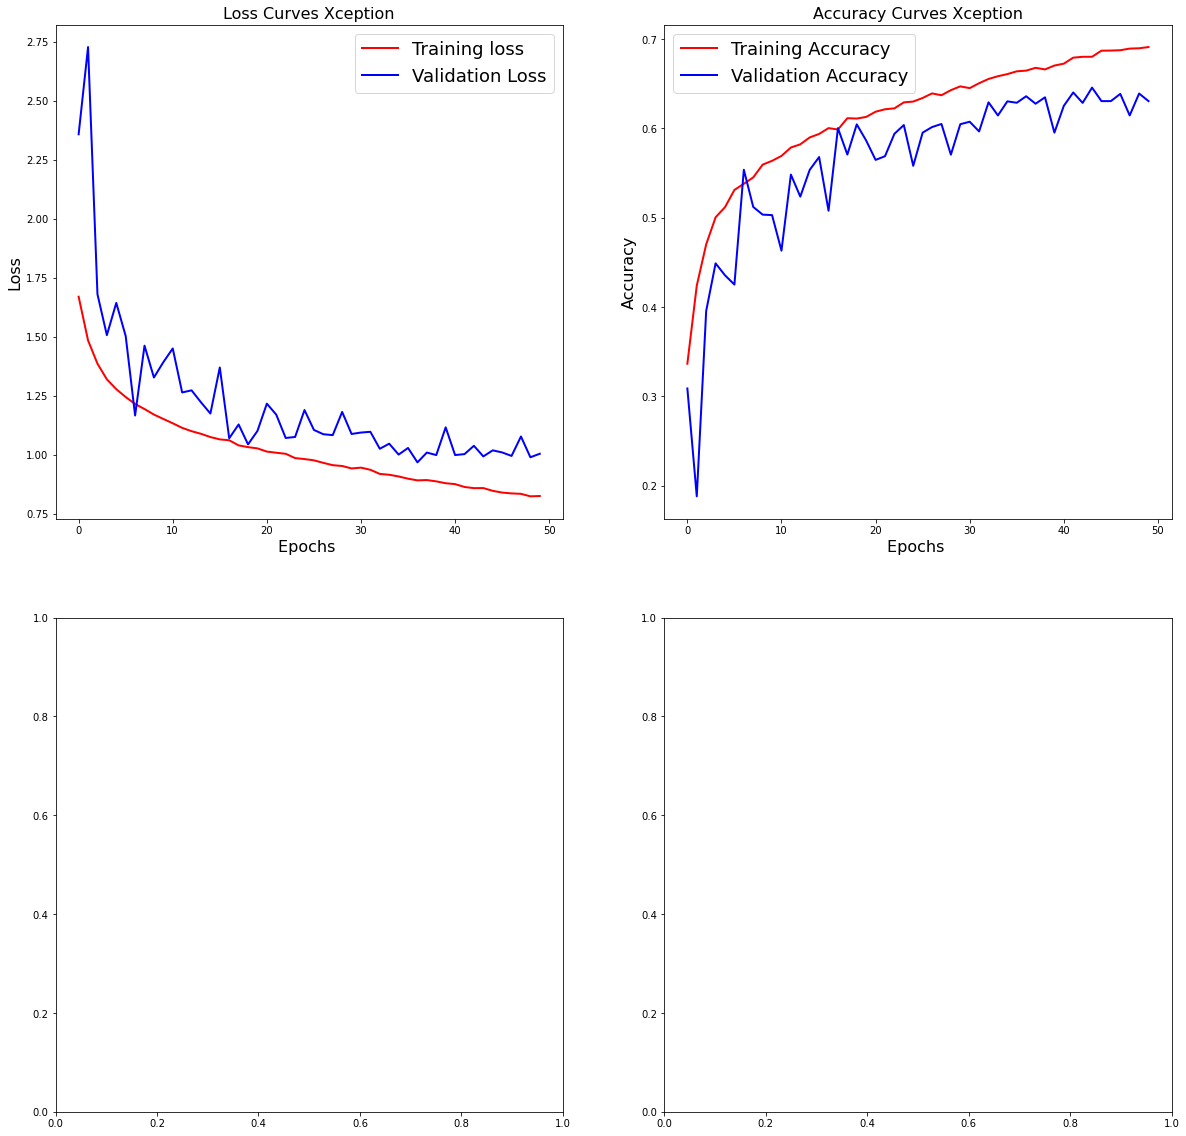

In [33]:
fig,axes=plt.subplots(2,2,figsize=(20, 20))
for (m,history), ax in zip({'Xception':xception_history}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [34]:
for model in [xception]:
    ypred=model.predict(xtest)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(ytest, axis=1)
    print(classification_report(ytest_, ypred_,digits=3))
    

              precision    recall  f1-score   support

           0      0.547     0.547     0.547       481
           1      0.542     0.473     0.505        55
           2      0.466     0.473     0.469       463
           3      0.850     0.861     0.856       792
           4      0.508     0.561     0.533       481
           5      0.732     0.728     0.730       356
           6      0.642     0.579     0.609       603

    accuracy                          0.640      3231
   macro avg      0.612     0.603     0.607      3231
weighted avg      0.642     0.640     0.640      3231



In [36]:
xtest.shape

(3231, 48, 48, 1)

In [37]:
from PIL import Image


In [38]:
img = Image.open("C:/class/photo_Haotian Xu.jpg")
img.show()

In [41]:
img = img_to_array(img)
img = resize(img,[48,48])
img = rgb_to_grayscale(img)
img.shape

TensorShape([48, 48, 1])

In [44]:
img = expand_dims(img,axis=0)

In [45]:
xception.predict(img)

array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)